# llama2 pretraining with BitLinear 日本語データ using mybitnet

## Install

In [1]:
!git clone --branch follow-2B4T-paper --single-branch https://github.com/yfuka/BitNet-b158-2b4t.git

Cloning into 'BitNet-b158-2b4t'...
remote: Enumerating objects: 252, done.
remote: Counting objects: 100% (252/252), done.
remote: Compressing objects: 100% (159/159), done.
remote: Total 252 (delta 118), reused 208 (delta 81), pack-reused 0 (from 0)
Receiving objects: 100% (252/252), 68.72 KiB | 562.00 KiB/s, done.
Resolving deltas: 100% (118/118), done.


In [2]:
import sys
sys.path.append('/content/BitNet-b158-2b4t')

In [3]:
!pip install -U accelerate transformers==4.47.1
!pip install torch datasets wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 432.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 92.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [4]:
!transformers-cli env

2025-05-05 23:07:36.842962: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-05 23:07:36.861339: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746486456.887828     783 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746486456.894262     783 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-05 23:07:36.918004: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [ ]:
from huggingface_hub import login

login()

## Setup
- load tokenizer
- set max_token_length

In [6]:
import re
import multiprocessing
from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer

In [7]:
# ── 設定 ─────────────────────────────
# MODEL_NAME      = "rinna/japanese-gpt-neox-3.6b"
MODEL_NAME = "tokyotech-llm/Swallow-7b-hf"
MAX_LENGTH      = 1024   # チャンクの最大トークン数（BOS/EOS を含む）
MIN_SENT_TOKENS = 10     # これ以下の文は捨てる
NUM_PROC        = multiprocessing.cpu_count()
print(NUM_PROC)

# ── トークナイザーのロード ───────────────────
# tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=False)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

12


tokenizer_config.json:   0%|          | 0.00/773 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/914k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/457 [00:00<?, ?B/s]

In [8]:
# 特殊トークンのマップを表示
print(tokenizer.special_tokens_map)
# → e.g. {'eos_token': '</s>'}

# 個別に確認
print("BOS token:", tokenizer.bos_token, "→ id:", tokenizer.bos_token_id)
print("EOS token:", tokenizer.eos_token, "→ id:", tokenizer.eos_token_id)

{'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>'}
BOS token: <s> → id: 1
EOS token: </s> → id: 2


## PrepData Wikipedia

In [10]:
from datasets import load_dataset, DatasetDict

ds_name = "range3/wiki40b-ja"
ds_train = load_dataset(ds_name, split="train")
ds_valid = load_dataset(ds_name, split="validation")

raw_datasets = DatasetDict(
    {
        "train": ds_train,  # .shuffle().select(range(50000))
        "valid": ds_valid,  # .shuffle().select(range(500))
    }
)

raw_datasets

README.md:   0%|          | 0.00/656 [00:00<?, ?B/s]

train.parquet:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

validation.parquet:   0%|          | 0.00/66.1M [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/66.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/745392 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/41576 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/41268 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['wikidata_id', 'text', 'version_id'],
        num_rows: 745392
    })
    valid: Dataset({
        features: ['wikidata_id', 'text', 'version_id'],
        num_rows: 41576
    })
})

In [11]:
# ── テキストクリーニング ─────────────────────
def clean_text(text: str) -> str:
    for tok in ("_START_ARTICLE_", "_START_SECTION_", "_START_PARAGRAPH_", "_NEWLINE_"):
        text = text.replace(tok, "")
    return re.sub(r"\s+", " ", text).strip()

# ── 文単位チャンク化（テキスト→ネストされたリスト） ────
def clean_and_chunk_batch(batch):
    all_input_ids = []
    all_lengths   = []
    for text in batch["text"]:
        # 1) プレーンテキストをクリーン
        txt = clean_text(text)
        # 2) 文ごとに分割
        sents = re.split(r'(?<=[。!?！？])\s*', txt)
        # 3) 一度にトークナイズして文ごとの長さ取得
        tmp = tokenizer(sents, truncation=False, add_special_tokens=False)
        sent_ids = tmp["input_ids"]
        sent_lens = [len(ids) for ids in sent_ids]
        # 4) 有効な文だけ残す
        valid = [
            (sents[i], sent_ids[i], sent_lens[i])
            for i in range(len(sents))
            if MIN_SENT_TOKENS <= sent_lens[i] <= (MAX_LENGTH - 2)
        ]
        # 5) 文を積んでプレーンテキストチャンクを作成
        chunk_texts = []
        cur_txt, cur_len = [], 0
        for s_str, ids, ln in valid:
            if cur_len + ln <= (MAX_LENGTH - 2):
                cur_txt.append(s_str)
                cur_len += ln
            else:
                if cur_txt:
                    chunk_texts.append("".join(cur_txt))
                cur_txt, cur_len = [s_str], ln
        if cur_txt:
            chunk_texts.append("".join(cur_txt))
        # 6) 各チャンクを再トークナイズして BOS/EOS を付与
        batch_ids = []
        batch_lens = []
        for txt_chunk in chunk_texts:
            ids = tokenizer(txt_chunk, truncation=False, add_special_tokens=False)["input_ids"]
            if tokenizer.bos_token_id is not None:
                ids = [tokenizer.bos_token_id] + ids
            if tokenizer.eos_token_id is not None:
                ids = ids + [tokenizer.eos_token_id]
            batch_ids.append(ids)
            batch_lens.append(len(ids))
        all_input_ids.append(batch_ids)
        all_lengths.append(batch_lens)
    return {"input_ids": all_input_ids, "length": all_lengths}

# ── 生成されたネスト済みリストをチャンク単位で展開 ────────
def split_chunks(batch):
    out_ids, out_lens = [], []
    for ids_list, lens_list in zip(batch["input_ids"], batch["length"]):
        for ids, ln in zip(ids_list, lens_list):
            out_ids.append(ids)
            out_lens.append(ln)
    return {"input_ids": out_ids, "length": out_lens}

In [12]:
# ── ① クリーニング＆ネストチャンク化 ──────────────
processed = raw_datasets.map(
    clean_and_chunk_batch,
    batched=True,
    num_proc=NUM_PROC,
    remove_columns=raw_datasets["train"].column_names
)

# ── ② ネストを平坦化（チャンク単位で行を増やす） ───────
tokenized_datasets_wiki = processed.map(
    split_chunks,
    batched=True,
    num_proc=NUM_PROC,
    remove_columns=processed["train"].column_names
)

Map (num_proc=12):   0%|          | 0/745392 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/41576 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/745392 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/41576 [00:00<?, ? examples/s]

493553939


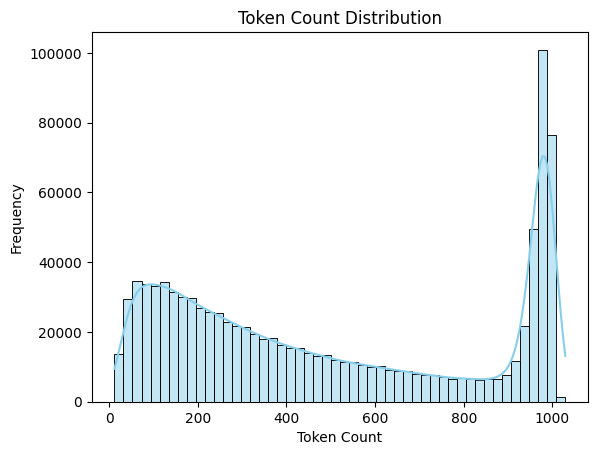

In [13]:
lengths = tokenized_datasets_wiki['train']['length']
print(sum(lengths))

import seaborn as sns
import matplotlib.pyplot as plt

# ヒストグラムとカーネル密度推定を描画
sns.histplot(lengths, bins=50, kde=True, color='skyblue')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.title('Token Count Distribution')
plt.show()

## PrepData Aozorabunko

In [14]:
from datasets import load_dataset, DatasetDict

# データセット読み込み & フィルタリング
ds = load_dataset('globis-university/aozorabunko-clean')
ds = ds.filter(lambda row: row['meta']['文字遣い種別'] == '新字新仮名')

# train スプリットを 80%/20% に分割
split_ds = ds['train'].train_test_split(test_size=0.2, seed=42)

# 'test' を 'valid' にリネームして DatasetDict を作成
raw_datasets = DatasetDict({
    'train': split_ds['train'],
    'valid': split_ds['test'],   # もともとの 'test' が検証用データになります
})

# 確認
print(raw_datasets)
print("train:", len(raw_datasets['train']), "valid:", len(raw_datasets['valid']))

README.md:   0%|          | 0.00/2.96k [00:00<?, ?B/s]

aozorabunko-dedupe-clean.jsonl.gz:   0%|          | 0.00/241M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16951 [00:00<?, ? examples/s]

Filter:   0%|          | 0/16951 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'footnote', 'meta'],
        num_rows: 8196
    })
    valid: Dataset({
        features: ['text', 'footnote', 'meta'],
        num_rows: 2050
    })
})
train: 8196 valid: 2050


In [15]:
# ── テキストクリーニング ─────────────────────
def clean_text(text: str) -> str:
    return text

# ── 文単位チャンク化（テキスト→ネストされたリスト） ────
def clean_and_chunk_batch(batch):
    all_input_ids = []
    all_lengths   = []
    for text in batch["text"]:
        # 1) プレーンテキストをクリーン
        txt = clean_text(text)
        # 2) 文ごとに分割
        sents = re.split(r'(?<=[。!?！？])\s*', txt)
        # 3) 一度にトークナイズして文ごとの長さ取得
        tmp = tokenizer(sents, truncation=False, add_special_tokens=False)
        sent_ids = tmp["input_ids"]
        sent_lens = [len(ids) for ids in sent_ids]
        # 4) 短すぎる/長すぎる文は除く
        valid = [
            (sents[i], sent_ids[i], sent_lens[i])
            for i in range(len(sents))
            if MIN_SENT_TOKENS <= sent_lens[i] <= (MAX_LENGTH - 2)
        ]
        # 5) 文を積んでプレーンテキストチャンクを作成
        chunk_texts = []
        cur_txt, cur_len = [], 0
        for s_str, ids, ln in valid:
            if cur_len + ln <= (MAX_LENGTH - 2):
                cur_txt.append(s_str)
                cur_len += ln
            else:
                if cur_txt:
                    chunk_texts.append("".join(cur_txt))
                cur_txt, cur_len = [s_str], ln
        if cur_txt:
            chunk_texts.append("".join(cur_txt))
        # 6) 各チャンクを再トークナイズして BOS/EOS を付与
        batch_ids = []
        batch_lens = []
        for txt_chunk in chunk_texts:
            ids = tokenizer(txt_chunk, truncation=False, add_special_tokens=False)["input_ids"]
            if tokenizer.bos_token_id is not None:
                ids = [tokenizer.bos_token_id] + ids
            if tokenizer.eos_token_id is not None:
                ids = ids + [tokenizer.eos_token_id]
            batch_ids.append(ids)
            batch_lens.append(len(ids))
        all_input_ids.append(batch_ids)
        all_lengths.append(batch_lens)
    return {"input_ids": all_input_ids, "length": all_lengths}

# ── 生成されたネスト済みリストをチャンク単位で展開 ────────
def split_chunks(batch):
    out_ids, out_lens = [], []
    for ids_list, lens_list in zip(batch["input_ids"], batch["length"]):
        for ids, ln in zip(ids_list, lens_list):
            out_ids.append(ids)
            out_lens.append(ln)
    return {"input_ids": out_ids, "length": out_lens}

In [16]:
# ── ① クリーニング＆ネストチャンク化 ──────────────
processed = raw_datasets.map(
    clean_and_chunk_batch,
    batched=True,
    num_proc=NUM_PROC,
    remove_columns=raw_datasets["train"].column_names
)

# ── ② ネストを平坦化（チャンク単位で行を増やす） ───────
tokenized_datasets_aozora = processed.map(
    split_chunks,
    batched=True,
    num_proc=NUM_PROC,
    remove_columns=processed["train"].column_names
)

Map (num_proc=12):   0%|          | 0/8196 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/2050 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/8196 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/2050 [00:00<?, ? examples/s]

In [17]:
tokenized_datasets_aozora

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'length'],
        num_rows: 108767
    })
    valid: Dataset({
        features: ['input_ids', 'length'],
        num_rows: 27526
    })
})

101423580


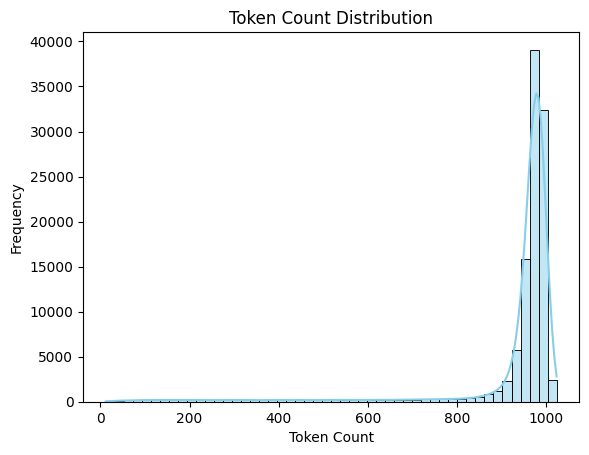

In [18]:
lengths = tokenized_datasets_aozora['train']['length']
print(sum(lengths))

import seaborn as sns
import matplotlib.pyplot as plt

# ヒストグラムとカーネル密度推定を描画
sns.histplot(lengths, bins=50, kde=True, color='skyblue')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.title('Token Count Distribution')
plt.show()

## Merge courpus

In [19]:
from datasets import concatenate_datasets

merged_tokenized_datasets = DatasetDict({
    split: concatenate_datasets([tokenized_datasets_wiki[split], tokenized_datasets_aozora[split]])
    for split in ("train", "valid")
})

In [20]:
import numpy as np
from datasets import DatasetDict


def sort_splits_by_length(tokenized_datasets: DatasetDict, splits: tuple = ("train", "valid")) -> DatasetDict:
    """
    tokenized_datasets の指定したスプリットを 'length' カラムで昇順ソートし、
    新しい DatasetDict として返す。

    Args:
        tokenized_datasets (DatasetDict): 'train', 'valid' などのスプリットを含む DatasetDict
        splits (tuple): ソート対象のスプリット名タプル（デフォルト: ("train", "valid")）

    Returns:
        DatasetDict: 各スプリットが 'length' 昇順ソートされた DatasetDict
    """
    sorted_splits = {}
    for split in splits:
        ds = tokenized_datasets[split]
        # 1) 'length' カラムを NumPy 配列として取得
        lengths = np.array(ds["length"])
        # 2) argsort で昇順インデックスを計算
        idxs = np.argsort(lengths)
        # 3) select() で再配置
        sorted_splits[split] = ds.select(idxs.tolist())

    # 新しい DatasetDict を返す
    return DatasetDict(sorted_splits)

filtered_sorted_tokenized_datasets = sort_splits_by_length(merged_tokenized_datasets)
print(filtered_sorted_tokenized_datasets)

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'length'],
        num_rows: 1097497
    })
    valid: Dataset({
        features: ['input_ids', 'length'],
        num_rows: 82279
    })
})


594977519


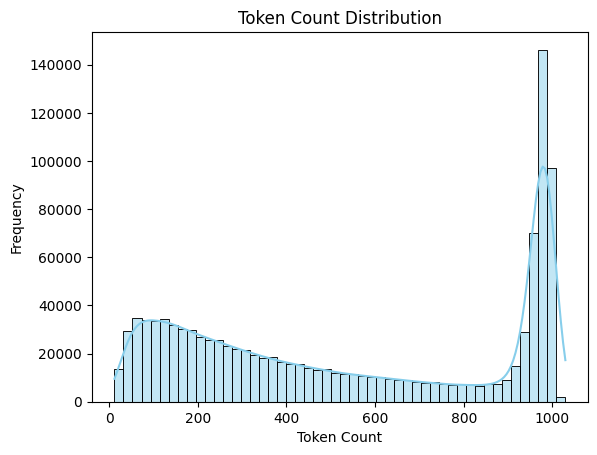

In [21]:
lengths = filtered_sorted_tokenized_datasets['train']['length']
print(sum(lengths))

import seaborn as sns
import matplotlib.pyplot as plt

# ヒストグラムとカーネル密度推定を描画
sns.histplot(lengths, bins=50, kde=True, color='skyblue')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.title('Token Count Distribution')
plt.show()

## Define Model

In [23]:
# 特定のAutoクラス（特にモデルの場合）に正しく登録するようライブラリに指示
# refers: https://huggingface.co/docs/transformers/v4.38.2/ja/custom_models#sending-the-code-to-the-hub
from mybitnet import BitLlamaConfig, BitLlamaForCausalLM

BitLlamaConfig.register_for_auto_class()
BitLlamaForCausalLM.register_for_auto_class("AutoModelForCausalLM")

In [ ]:
from mybitnet import BitLlamaConfig, BitLlamaForCausalLM
import torch

tokenizer.pad_token = tokenizer.eos_token
config = BitLlamaConfig(
    model_type="bit_llama",
    bitnet_type="1.58b",              # BitNet b158: "1.58b", BitNet: "1b"
    vocab_size=len(tokenizer),
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id,
    hidden_size=768,                  # BitNet論文より
    max_position_embeddings=MAX_LENGTH,
    intermediate_size=1536,
    num_attention_heads=12,         # BitNet論文より
    num_hidden_layers=12,            # BitNet論文より
    num_key_value_heads=4,
    torch_dtype=torch.bfloat16,
    rms_norm_eps=1e-06,
    hidden_act="relu2",         # BitNet-2B4T論文より
)
print(config)

BitLlamaConfig {
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bitnet_type": "1.58b",
  "bits": 8,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "head_dim": 64,
  "hidden_act": "relu2",
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "max_position_embeddings": 1024,
  "mlp_bias": false,
  "model_type": "bit_llama",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_key_value_heads": 4,
  "pad_token_id": 2,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.47.1",
  "use_cache": true,
  "vocab_size": 43176
}



In [26]:
model = BitLlamaForCausalLM(config)
print(model)

BitLlamaForCausalLM(
  (model): BitLlamaModel(
    (embed_tokens): Embedding(43176, 768, padding_idx=2)
    (layers): ModuleList(
      (0-11): 12 x BitLlamaDecoderLayer(
        (self_attn): BitLlamaSdpaAttention(
          (q_proj): BitLinear158b(
            in_features=768, out_features=768, bias=False
            (layernorm): BitRMSNorm()
          )
          (k_proj): BitLinear158b(
            in_features=768, out_features=256, bias=False
            (layernorm): BitRMSNorm()
          )
          (v_proj): BitLinear158b(
            in_features=768, out_features=256, bias=False
            (layernorm): BitRMSNorm()
          )
          (o_proj): BitLinear158b(
            in_features=768, out_features=768, bias=False
            (layernorm): BitRMSNorm()
          )
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): BitLlamaMLP(
          (gate_proj): BitLinear158b(
            in_features=768, out_features=1536, bias=False
            (layernorm): BitRMS

In [27]:
model_size = sum(t.numel() for t in model.parameters())
print(f"model size: {model_size/1000**2:.1f}M parameters")

model size: 127.7M parameters


## Train

In [ ]:
import wandb

wandb.init(
    project="bitnet",
    name="myBit-Llama2-jp-127M-2B4TLike-wiki-aozora-sort-swallow-tokenizer",
)

In [29]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

In [30]:
from transformers import Trainer, TrainingArguments

args = TrainingArguments(
    output_dir="myBit-Llama2-jp-127M-2B4TLike-wiki-aozora-sort-swallow-tokenizer",
    per_device_train_batch_size=24,
    per_device_eval_batch_size=24,
    eval_strategy="steps",
    eval_steps=500,
    logging_steps=500,
    gradient_accumulation_steps=4,
    num_train_epochs=1,
    warmup_steps=750,
    lr_scheduler_type="linear",  # BitNet論文より
    learning_rate=2.4e-3,  # BitNet論文より
    save_steps=500,
    bf16=True,
    push_to_hub=True,
    report_to="wandb",
    save_total_limit=3,
    adam_beta1=0.9,  # BitNet論文より
    adam_beta2=0.95,  # BitNet論文より
    weight_decay=0.1,  # BitNet論文より
    dataloader_pin_memory=True,
    torch_compile=True,
    dataloader_drop_last=True,
)

In [31]:
from transformers import Trainer
from torch.utils.data import DataLoader, SequentialSampler

class NoShuffleTrainer(Trainer):
    def get_train_dataloader(self) -> DataLoader:
        return DataLoader(
            self.train_dataset,
            batch_size=self.args.train_batch_size,
            sampler=SequentialSampler(self.train_dataset),
            collate_fn=self.data_collator,
        )

In [32]:
trainer = NoShuffleTrainer(
    model=model,
    tokenizer=tokenizer,
    args=args,
    data_collator=data_collator,
    train_dataset=filtered_sorted_tokenized_datasets["train"],
    eval_dataset=filtered_sorted_tokenized_datasets["valid"],
)

<ipython-input-32-fa0b6ad1a1e8>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `NoShuffleTrainer.__init__`. Use `processing_class` instead.
  trainer = NoShuffleTrainer(


In [33]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss
500,5.021700,5.596691
1000,3.865500,4.963590
1500,3.579800,4.588921
2000,3.433100,4.368504
2500,3.337100,4.241512
3000,3.291200,4.131889
3500,3.225500,4.016711
4000,3.186300,3.905683
4500,3.154900,3.725677
5000,3.123700,3.642163


Step,Training Loss,Validation Loss
500,5.021700,5.596691
1000,3.865500,4.963590
1500,3.579800,4.588921
2000,3.433100,4.368504
2500,3.337100,4.241512
3000,3.291200,4.131889
3500,3.225500,4.016711
4000,3.186300,3.905683
4500,3.154900,3.725677
5000,3.123700,3.642163


TrainOutput(global_step=11432, training_loss=3.2838612710620407, metrics={'train_runtime': 24430.4097, 'train_samples_per_second': 44.923, 'train_steps_per_second': 0.468, 'total_flos': 3.3761605343883264e+17, 'train_loss': 3.2838612710620407, 'epoch': 0.9999562650338946})

In [ ]:
trainer.push_to_hub()

In [35]:
from google.colab import runtime
runtime.unassign()

### モデル取得 試し

In [ ]:
import sys
sys.path.append('/content/BitNet-b158-2b4t')

In [4]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "yusuke111/myBit-Llama2-jp-127M-2B4TLike-wiki-aozora-sort-swallow-tokenizer"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.bfloat16, device_map="auto", trust_remote_code=True)
print(model)

tokenizer_config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/914k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.38M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/434 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/886 [00:00<?, ?B/s]

modeling_bit_llama.py:   0%|          | 0.00/9.94k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/yusuke111/myBit-Llama2-jp-127M-2B4TLike-wiki-aozora-sort-swallow-tokenizer:
- modeling_bit_llama.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/511M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

BitLlamaForCausalLM(
  (model): BitLlamaModel(
    (embed_tokens): Embedding(43176, 768, padding_idx=2)
    (layers): ModuleList(
      (0-11): 12 x BitLlamaDecoderLayer(
        (self_attn): BitLlamaSdpaAttention(
          (q_proj): BitLinear158b(
            in_features=768, out_features=768, bias=False
            (layernorm): BitRMSNorm()
          )
          (k_proj): BitLinear158b(
            in_features=768, out_features=256, bias=False
            (layernorm): BitRMSNorm()
          )
          (v_proj): BitLinear158b(
            in_features=768, out_features=256, bias=False
            (layernorm): BitRMSNorm()
          )
          (o_proj): BitLinear158b(
            in_features=768, out_features=768, bias=False
            (layernorm): BitRMSNorm()
          )
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): BitLlamaMLP(
          (gate_proj): BitLinear158b(
            in_features=768, out_features=1536, bias=False
            (layernorm): BitRMS

In [5]:
print(tokenizer)

LlamaTokenizerFast(name_or_path='yusuke111/myBit-Llama2-jp-127M-2B4TLike-wiki-aozora-sort-swallow-tokenizer', vocab_size=43176, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '</s>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
)


In [10]:
prompt = "夏目漱石は、"
inputs = tokenizer(prompt, return_tensors="pt")
inputs = {k: v.to(model.device) for k, v in inputs.items()}
tokens = model.generate(
    input_ids=inputs["input_ids"],
    attention_mask=inputs["attention_mask"],
    pad_token_id=tokenizer.eos_token_id,
    max_new_tokens=128,
    repetition_penalty=1.3,
)

out = tokenizer.decode(tokens[0], skip_special_tokens=True)
print(out)

夏目漱石は、「私の心を恢復することができない」と述べた。1960年（昭和35年）には、『新潮』誌上で、「私の心を昂揚したい」という言葉を引用した。この記事は、「私の心を撞着させるために、私の心を攫っているようなものだ」として、「私の心を撞着させてほしい」という趣旨の文章を掲載した。これらの文章は、「私の心を�


In [12]:
prompt = "こんにちは、"
inputs = tokenizer(prompt, return_tensors="pt")
inputs = {k: v.to(model.device) for k, v in inputs.items()}
tokens = model.generate(
    input_ids=inputs["input_ids"],
    attention_mask=inputs["attention_mask"],
    pad_token_id=tokenizer.pad_token_id,
    max_new_tokens=128,
    repetition_penalty=1.3,
)

out = tokenizer.decode(tokens[0], skip_special_tokens=True)
print(out)

こんにちは、お父さんは、このごろのことを思いだしたようです。それから、私たちが、あの人に、何か、そんなことを言っているという話もありました。その時、私たちは、もう一度、お母さまへ、お礼を申し上げてみますと、お父様は、お父様の御前で、お父様のお言葉を聞いていられませんでしたか」
「そうだよ、お父様は、お父様のお心持がよくわかるものじゃないか」
　こういって


In [ ]:
from google.colab import runtime
runtime.unassign()